# Tarea 1. Métodos de Descenso para Funciones de Base Radial (RBFs)

**Enya Tovar Estrada**

Fecha de entrega: 01 Marzo 2024


**Instrucciones**

Resolver el problema de ajuste de RBFs:

• Usar una imagen momocromática (tonos de gris) de 256x256 pixeles.

• Usar entre 100 a 500 funciones radiales. Encuentre el compromiso que
le parezca adecuado entre buena reconstrucción y rapidez en la reconstrucción, esto es a su criterio.

• Los centros θ de las funciones radiales se inicializan aleatoriamente en el intervalo [1,N]

• Busque un valor de κ adecuado para la imagen de prueba que seleccione.

• Ajustar el modelo usando la multiquádrica y compara con la la Gaussiana

• Usar los métodos de descenso de gradiente: GD, Nesterov y Adam. Puede, si le parece conveniente, implementar la versión estocástica.

• Incluir una penalización (regularización) en las α´s: Esto es añadir a la función objetivo el término λ∥α∥^2 , donde λ es un parámetro que controla cuantas α se expresan.


**Librerías.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
import urllib.request

**Cargar imagen y ajustar.**

In [3]:
#Descarga de la imagen
Archivo="Imagen.png"
urllib.request.urlretrieve("https://images.wikidexcdn.net/mwuploads/esssbwiki/7/74/latest/20230328205524/Shy_Guy_%28Mario_Party_Superstars%29.png", Archivo)
D_Imagen = Archivo
Imagen = cv2.imread(D_Imagen, cv2.IMREAD_GRAYSCALE)

Dimensiones originales de la imagen: 
 Altura=955 y Ancho=853


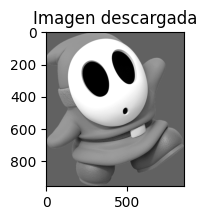

In [4]:
#Revisamos algunas características de la imgen y la imprimimos c:
altura, ancho = Imagen.shape[:2]
print(f"Dimensiones originales de la imagen: \n Altura={altura} y Ancho={ancho}")
plt.figure(figsize=(6, 2))
plt.imshow(Imagen,cmap='gray')
plt.title('Imagen descargada')
plt.show()

In [5]:
#Para trabajar hay que hacerle un re-size
#Voy a trabajar con pocas dimensiones para que no tome tanto tiempo compilar
#De igual forma la imagen es muy grande por lo que puedo hacer el resize que se pide de 256 x 256 después
dimension = 30
Imagen_redim = cv2.resize(Imagen, (dimension,dimension))
#Normalizamos
Imagen_norm = Imagen_redim/255

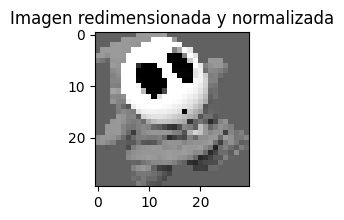

In [6]:
#Volvemos a imprimir ya la imagen normalizada
plt.figure(figsize=(6, 2))
plt.imshow(Imagen_norm, cmap='gray')
plt.title('Imagen redimensionada y normalizada')
plt.show()

**Gaussiana y Multiquádrica.**

In [7]:
#Tenemos que ajustar el modelo usando la multiquadrica y comparar con la Gaussiana.
#Gaussiana
def gaussiana(r,k):
  return np.exp(-k*(r**2))
#Multiquádrica
def multiquadratica(r,k):
  return np.sqrt((r**2) + k)

In [8]:
#Gaussiana
def derivada_gaussiana(alpha, x, theta, k):
    #Norma entre theta y x
    norma = np.linalg.norm(theta - x)
    #Derivada de la función gaussiana
    derivada = np.ones(2)
    derivada[0] = (x[0] - theta[0])
    derivada[1] = (x[1] - theta[1])

    z = -2 * alpha * k * np.exp(-k * norma**2) * derivada
    return z

#Multiquádrica
def derivada_multiquadratica(alpha, x, theta, k):
    norma = np.linalg.norm(theta - x)
    #Derivada de la función multiquadrica
    derivada = np.ones(2)
    derivada[0] = (x[0] - theta[0])
    derivada[1] = (x[1] - theta[1])

    #Calcula la derivada de la función radial multiquadrica
    return alpha * (-2 * norma) / np.sqrt(norma**2 + k) * derivada

**Matriz_phi.**

In [9]:
def calcular_matriz_phi(puntos_datos, centros, funcion_radial, k):
    #Inicializamos la matriz con ceros
    Matriz_phi = np.zeros((len(puntos_datos), len(centros)))

    #Iteramos sobre los puntos de datos
    for i in range(len(puntos_datos)):
        #Iteramos sobre los centros de los clusteres
        for j in range(len(centros)):
            #Calculamos la distancia entre el punto de datos y el centro del clúster
            r = np.linalg.norm(puntos_datos[i] - centros[j])
            #Calculamos el valor de la función radial para la distancia r
            Matriz_phi[i,j] = funcion_radial(r,k)

    return Matriz_phi

**Coeficientes alpha.**

In [10]:
#Coeficientes alpha para el modelo.
def calcular_alpha(objetivo, x, N, funcion_radial, theta, kappa, alpha_reg=0.1):
    # Generar la matriz phi
    matriz_phi = calcular_matriz_phi(x, theta, funcion_radial, kappa)

    # Calcular los coeficientes alpha utilizando regularización de Tikhonov
    matriz_regularizada = matriz_phi.T @ matriz_phi + alpha_reg * np.identity(N)
    coeficientes_alpha = np.linalg.solve(matriz_regularizada, matriz_phi.T @ objetivo)

    return coeficientes_alpha

**Gradiente Matriz_phi.**

In [11]:
def calcular_gradiente_phi(x, alpha, theta, objetivo, funcion_radial, funcion_derivada, k):
    M_phi = calcular_matriz_phi(x, theta, funcion_radial, k)
    M = M_phi @ alpha
    gradiente = np.zeros(theta.shape)

    for i in range(len(theta)):
        for j in range(len(x)):
            z = (objetivo[j] - M[j]) * funcion_derivada(alpha[i], x[j], theta[i], k)
            #Actualizamos el gradiente
            gradiente[i] = gradiente[i] + z

    return gradiente

**Función Objetivo.**

In [12]:
def funcion_objetivo(Matriz_phi, objetivo, alpha, lambda_):
    #Realizamos la predicción multiplicando la matriz phi por los coeficientes alpha del modelo
    predicciones = Matriz_phi @ alpha
    #Calculamos el error cuadrático
    error_cuadratico_medio = np.sum((objetivo - predicciones)**2) / 2
    #Calculamos el término de regularización para penalizar
    termino_regularizacion = lambda_ *np.sum(alpha**2)
    #Valor de la función objetivo combinando el error cuadrático y el término de regularización
    valor_funcion_objetivo = error_cuadratico_medio + termino_regularizacion

    return valor_funcion_objetivo

**Métodos de descenso de gradiente.**

**GD**

In [13]:
#Descenso gradiente
def GD(theta_inicial, maxIter, tasa_aprendizaje, calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, k):
    # Inicializamos los parámetros theta con los valores iniciales
    theta = theta_inicial
    # Iteramos hasta alcanzar el número máximo de iteraciones
    for i in range(maxIter):
        #Calculamos el gradiente de la función de costo
        gradiente = calcular_gradiente_phi(x, alpha, theta, objetivo, funcion_radial, funcion_derivada, k)
        #Actualizamos los parámetros theta utilizando el gradiente y la tasa de aprendizaje
        theta = theta - tasa_aprendizaje * gradiente

    #Devolvemos los parámetros optimizados
    return theta

**Nesterov**

In [14]:
def Nesterov(theta_inicial, maxIter, a, b, calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, k):
    theta = theta_inicial
    p = np.zeros(theta.shape)

    for i in range(maxIter):
        pre_theta = theta - 2.0*a*p
        g = calcular_gradiente_phi(x, alpha, pre_theta, objetivo, funcion_radial, funcion_derivada, k)
        #Actualizamos el momento
        p = g + b*p
        #Actualizamos theta
        theta = pre_theta - a*p

    #Parámetros optimizados c:
    return theta

**ADAM**

In [15]:
def ADAM(theta_inicial, tasa_aprendizaje, beta1, beta2, epsilon, maxIter, calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, k):
    theta = theta_inicial
    cont = 0
    p1 = np.zeros(theta.shape)
    p2 = np.zeros(theta.shape)

    for i in range(maxIter):
        for j in range(len(theta)):
            cont += 1
            gradiente = calcular_gradiente_phi(x, alpha, theta, objetivo, funcion_radial, funcion_derivada, k)
            #Actualizamos los momentos p1 y p2
            p1 = beta1 * p1 + (1-beta1) * gradiente
            p2 = beta2 * p2 + (1-beta2) * (gradiente**2)
            #Corregimos los momentos sesgados
            p1_hat = p1 / (1- beta1**cont)
            p2_hat = p2 / (1- beta2**cont)
            #Actualizamos theta utilizando los momentos corregidos
            theta -= tasa_aprendizaje * p1_hat / (np.sqrt(p2_hat) + epsilon)

    return theta

**Reconstrucción de la imagen.**

In [16]:
# Vamos a reconstruir la imagen a partir de la matriz de características y los coeficientes alpha c:
def Reconstruccion_Imagen(longitud_x, longitud_y, alpha, x, theta, funcion_radial, kappa):
    phi = calcular_matriz_phi(x, theta, funcion_radial, kappa)
    reconstruida = phi @ alpha
    reconstruida = reconstruida.reshape(longitud_x, longitud_y)

    return reconstruida

**Procedimiento general.**

In [17]:
def Procesamiento(imagen, theta_inicial, iteraciones, tolerancia, J, funcion_radial, funcion_derivada, kappa, metodo, parametros):
    #Obtener las dimensiones de la imagen
    alto, ancho = imagen.shape
    theta1 = theta_inicial
    theta2 = np.random.uniform(1, alto + 1, size=(J, 2))
    #Generar las coordenadas x
    x = np.array([(i, j) for i in range(alto) for j in range(ancho)])
    #Aplanar la imagen
    objetivo = imagen.flatten()

    for i in range(iteraciones):
        #Calcular los coeficientes alpha
        alpha = calcular_alpha(objetivo, x, J, funcion_radial, theta1, kappa,alpha_reg=0.1)
        #Optimización según el método seleccionado...
        if metodo == 1:
            theta2 = GD(theta1, parametros[0], parametros[1], calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, kappa)
        elif metodo == 2:
            theta2 = Nesterov(theta1, parametros[0], parametros[1], parametros[2], calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, kappa)
        elif metodo == 3:
            theta2 = ADAM(theta1, parametros[0], parametros[1], parametros[2], parametros[3], parametros[4], calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, kappa)
        #Actualizar theta1 con los nuevos valores calculados
        theta1 = theta2

    #Reconstruir la imagen utilizando los parámetros optimizados
    imagen_reconstruida = Reconstruccion_Imagen(alto, ancho, alpha, x, theta2, funcion_radial, kappa)
    # Devolver la imagen reconstruida
    return imagen_reconstruida

# PROCESO CON FUNCIÓN DE BASE RADIAL GAUSSIANA

In [26]:
#Condiciones para los procesos
#Pregunté con los compañeros y me dijeron que el Kappa podías hacerlo al tanteo
#El profesor les dijo 1/(2*5**2) , o eso le funcionó a alguien de imagen 50x50
#Yo usaré 1/(2*3**2) porque mi imagen es más pequeña
Kappa = 1/(2*(3**2))
N=100 #Es la cota mínima porque no quiero que tarde mucho
theta1 = np.random.uniform(1,Imagen_norm.shape[0]+1, size=(N,2))

**Gauss-GD**

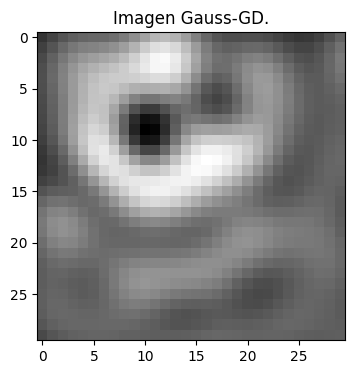

In [19]:
ParametrosF = [10, 1E-4]
ImagenFinalGaussGD = Procesamiento(Imagen_norm, theta1, 3, 1E-6, N, gaussiana, derivada_gaussiana, Kappa, 1, ParametrosF)
# Mostrar las imágenes
plt.figure(figsize=(8,4))
plt.imshow(ImagenFinalGaussGD, cmap='gray')
plt.title('Imagen Gauss-GD.')
plt.show()

**Gauss-Nesterov**

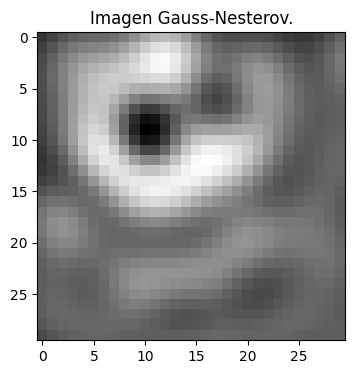

In [20]:
ParametrosN = [2, 1e-5, 1e-5]
ImagenFinalGaussNesterov = Procesamiento(Imagen_norm, theta1, 3, 1e-6, N, gaussiana, derivada_gaussiana, Kappa, 2, ParametrosN)
plt.figure(figsize=(8, 4))
plt.imshow(ImagenFinalGaussNesterov, cmap='gray')
plt.title('Imagen Gauss-Nesterov.')
plt.show()

**Gauss_ADAM**

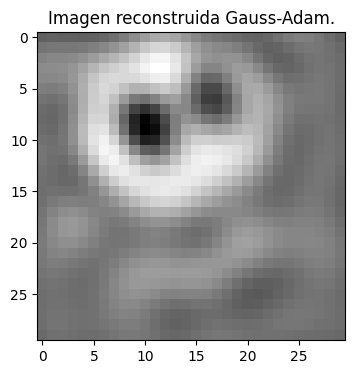

In [25]:
ParametrosA = [0.01, 0.9, 0.999, 1E-4, 5]
ImagenFinalGaussADAM = Procesamiento(Imagen_norm, theta1, 3, 1E-4, N, gaussiana, derivada_gaussiana, Kappa, 3, ParametrosA)
plt.figure(figsize=(8,4))
plt.imshow(ImagenFinalGaussADAM, cmap='gray')
plt.title('Imagen reconstruida Gauss-Adam.')
plt.show()

#PROCESO CON FUNCIÓN DE BASE RADIAL MULTICUADRÁTICA

In [22]:
#Vuelvo a definir no porque sea necesario, solo es por orden
Kappa = 1/(2*(3**2))
N=100
theta1 = np.random.uniform(1,Imagen_norm.shape[0]+1, size=(N,2))

Multicuadrática-GD

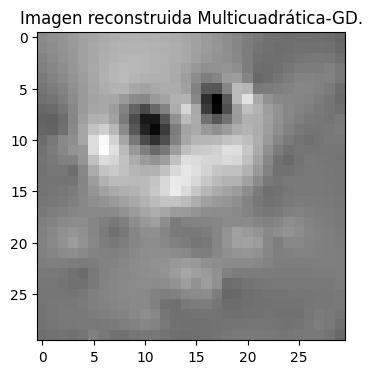

In [23]:
ParametrosF = [10, 1E-6]
ImagenFinalMulticuadraticaGD = Procesamiento(Imagen_norm, theta1, 3, 1E-6, N, multiquadratica, derivada_multiquadratica, Kappa, 1, ParametrosF)
# Mostrar las imágenes
plt.figure(figsize=(8, 4))
plt.imshow(ImagenFinalMulticuadraticaGD, cmap='gray')
plt.title('Imagen reconstruida Multicuadrática-GD.')
plt.show()

**Multicuadrática-Nesterov**

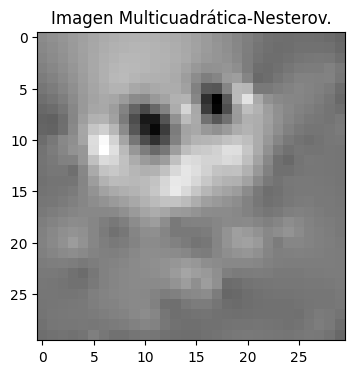

In [24]:
ParametrosN = [2, 1E-5, 1E-5]
ImagenFinalMulticuadraticaNesterov = Procesamiento(Imagen_norm, theta1, 3, 1E-6, N, multiquadratica, derivada_multiquadratica, Kappa, 2, ParametrosN)
plt.figure(figsize=(8,4))
plt.imshow(ImagenFinalMulticuadraticaNesterov, cmap='gray')
plt.title('Imagen Multicuadrática-Nesterov.')
plt.show()

**Multicuadrática-ADAM**

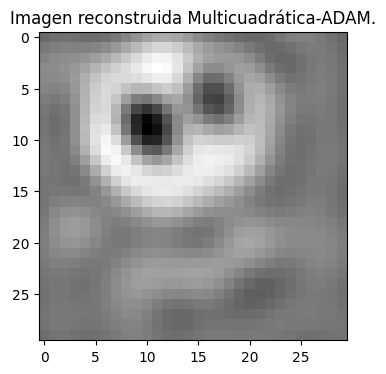

In [27]:
ParametrosA = [0.01, 0.9, 0.999, 1E-4, 5]
ImagenFinalMulticuadraticaADAM = Procesamiento(Imagen_norm, theta1, 3, 1E-6, N, gaussiana, derivada_gaussiana, Kappa, 3, ParametrosA)
plt.figure(figsize=(8,4))
plt.imshow(ImagenFinalMulticuadraticaADAM, cmap='gray')
plt.title('Imagen reconstruida Multicuadrática-ADAM.')
plt.show()

# RESULTADOS FINALES

**Vamos a comparar todas las reconstrucciones.**

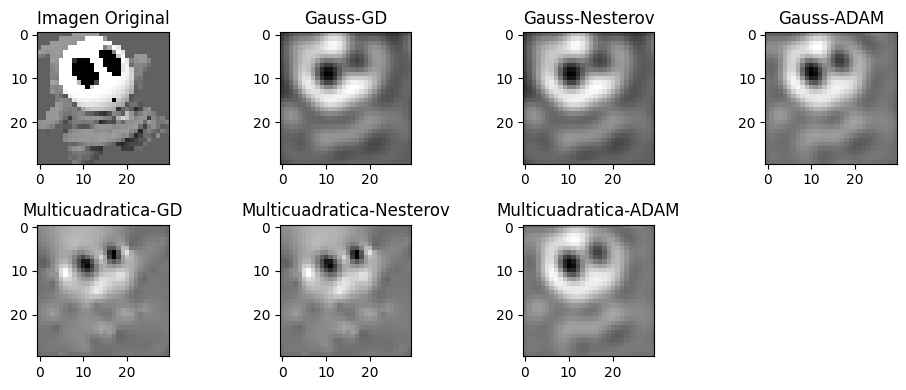

In [29]:
import matplotlib.pyplot as plt
imagenes = [Imagen_norm, ImagenFinalGaussGD, ImagenFinalGaussNesterov, ImagenFinalGaussADAM, ImagenFinalMulticuadraticaGD, ImagenFinalMulticuadraticaNesterov, ImagenFinalMulticuadraticaADAM]
T = ["Imagen Original", "Gauss-GD", "Gauss-Nesterov", "Gauss-ADAM", "Multicuadratica-GD", "Multicuadratica-Nesterov", "Multicuadratica-ADAM"]
plt.figure(figsize=(10,4))
for i in range(len(imagenes)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(imagenes[i], cmap='gray')
    plt.title(T[i])
plt.tight_layout()
plt.show()

Con las imagenes nos podemos dar cuenta que al emplear ADAM tuvimos una mejor reconstrucción de la imagen en ambas funciones radiales. Sin embargo, para poder establecer esto con mayor seguridad vamos a calcular un tipo de error, el **MSE**.

Vamos a calcular la diferencia cuadrática promedio entre los valores de píxeles originales y los valores de píxeles reconstruidos.

OJO entonces que un MSE bajo indica una reconstrucción mejor

In [30]:
def MSE(imagen_original,imagen_reconstruida):
    mse = np.mean((imagen_original - imagen_reconstruida) ** 2)
    return mse

mse_resultados = []
#Recorremos todas las imagenes, el arreglo está definido en la celda de arriba
for i in range(1, len(imagenes)):
    mse = MSE(imagenes[0], imagenes[i])
    mse_resultados.append(mse)

for i in range(1, len(mse_resultados) + 1):
    print(f"MSE {T[i]}:", mse_resultados[i - 1])

MSE Gauss-GD: 0.025494315758520795
MSE Gauss-Nesterov: 0.025496741661001368
MSE Gauss-ADAM: 0.019738361643338875
MSE Multicuadratica-GD: 0.023279293022108523
MSE Multicuadratica-Nesterov: 0.023298643326608682
MSE Multicuadratica-ADAM: 0.01919002817314176


Efectivamente podemos confirmar que los valores más pequeños (es decir las combinaciones que tuvieron mejor desempeño) fueron aquellas con **ADAM** y especificamente aquella que empleó **función radial multicuadratica**. 😃